# Check MWDC pulser data
The input parquet file should be the output of `streamingv1_to_parquet.py`

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

CH2NS = 0.0009765625 # AMANEQ HRTDC time unit to ns

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master("local[10]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark._jvm.decoders.HRTDCDecoder.registerUDF(spark._jsparkSession)

df = spark.read.parquet("parquet/run1008.parquet")

df_dc = df.filter("femType==5 and (femId==616 or femId==617 or femId==618)").select("femId","data").withColumn("decoded",F.expr("decode_hrtdc_segdata(data)"))
df_dc = df_dc.select("femId","decoded.*").select("femId","hbf.*","data").select("femId","hbfNumber","data").filter("array_size(decoded.data)>0")
df_dc = df_dc.withColumn("ex",F.explode("data")).select("femId","hbfNumber","ex.*")
df_dc = df_dc.withColumn("rand",F.rand().cast("float")).withColumn("tcal", (F.col("time").cast("float") + F.col("rand"))*F.lit(CH2NS).cast("float")).drop("time").drop("rand")
df_dc = df_dc.withColumn("rand",F.rand().cast("float")).withColumn("charge", (F.col("tot").cast("float") + F.col("rand"))*F.lit(CH2NS).cast("float")).drop("tot").drop("rand")
df_dc.show(1)

# Map dc31 and dc32
df_map31 = spark.read.csv("map/dc31_map.csv",inferSchema=True,header=True).withColumn("id",F.col("id").cast("int")).withColumn("femId",F.col("femId").cast("int")).withColumn("ch",F.col("ch").cast("int"))
df_dc31 = df_dc.join(df_map31,on=["ch","femId"]).drop("ch").drop("femId")
df_map32 = spark.read.csv("map/dc32_map.csv",inferSchema=True,header=True).withColumn("id",F.col("id").cast("int")).withColumn("femId",F.col("femId").cast("int")).withColumn("ch",F.col("ch").cast("int"))
df_dc32 = df_dc.join(df_map32,on=["ch","femId"]).drop("ch").drop("femId")

df_dc31.show(5)
df_dc32.show(5)

+-----+---------+---+---------+--------+
|femId|hbfNumber| ch|     tcal|  charge|
+-----+---------+---+---------+--------+
|  616| 12971992| 58|62203.926|81.13284|
+-----+---------+---+---------+--------+
only showing top 1 row
+---------+---------+---------+---+
|hbfNumber|     tcal|   charge| id|
+---------+---------+---------+---+
| 12971992|62203.926| 81.13284| 59|
| 12971992|62206.887|85.762505|  7|
| 12971992|62222.363|77.220604| 23|
| 12971992|62225.934| 72.66728| 43|
| 12971992|62237.508|33.823647| 42|
+---------+---------+---------+---+
only showing top 5 rows
+---------+---------+---------+---+
|hbfNumber|     tcal|   charge| id|
+---------+---------+---------+---+
| 12971992|62211.992|  94.6374| 24|
| 12971992| 62213.57|88.708206| 43|
| 12971992| 62227.21| 87.30695| 59|
| 12971992|62232.867|85.088264|  8|
| 12971993|225144.73| 93.69861|  8|
+---------+---------+---------+---+
only showing top 5 rows


# Plot charge vs id histogram for DC31
*Run this cell when the pulser signal is connected to DC31*
*Run next cell when it's connected to DC32*

Statistics:
[[0.000000e+00 1.100000e+01 0.000000e+00]
 [0.000000e+00 2.825541e+06 8.325900e+04]
 [0.000000e+00 0.000000e+00 0.000000e+00]]


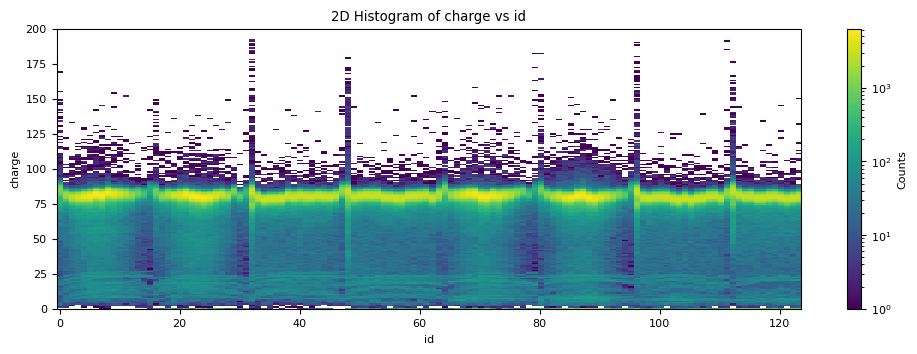

In [5]:
from hist.sparkHist2d import Hist2D
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(0, figsize=(12,8))
plt.rcParams["font.size"] = 8
plt.subplot2grid((2,1),(0,0))
h = Hist2D(df_dc31, ["id","charge"], [125,200], [[-0.5, 123.5], [0, 200]], norm=LogNorm(), interpolation='none')
plt.show()

## Plot charge vs id histogram for dc32

Statistics:
[[0.0000e+00 3.1000e+01 0.0000e+00]
 [0.0000e+00 8.1647e+05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00]]


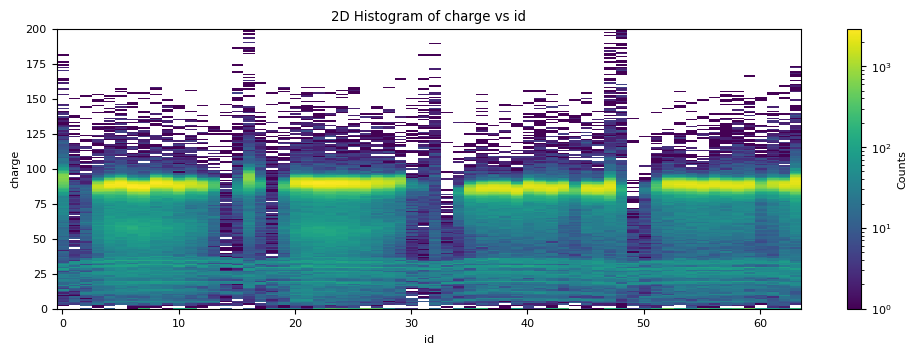

In [6]:
from hist.sparkHist2d import Hist2D
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(0, figsize=(12,8))
plt.rcParams["font.size"] = 8
#plt.subplot2grid((2,1),(0,0))
#h = Hist2D(df_dc31, ["id","charge"], [125,200], [[-0.5, 123.5], [0, 200]], norm=LogNorm(), interpolation='none')
plt.subplot2grid((2,1),(1,0))
h = Hist2D(df_dc32, ["id","charge"], [65,200], [[-0.5, 63.5], [0, 200]], norm=LogNorm(), interpolation='none')
plt.show()